In [1]:
%matplotlib inline

from importlib import reload
from helper_funcs import *
from make_models2 import *

# Make tqdm work for notebooks
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import pickle
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

/mmfs1/data/liacz/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Load data

In [2]:
import numpy as np
import os
indir = '/mmfs1/data/liacz/Documents/Bilingualism_CVAE/data/array_brains'
BRAIN_data = np.load(os.path.join(indir, "arr_combine/BRAIN_data.npy"))
DX_subs = np.load(os.path.join(indir, "arr_combine/DX_subs.npy"))
TD_subs = np.load(os.path.join(indir, "arr_combine/TD_subs.npy"))

In [3]:
# #BRAIN_data = np.array(BRAIN_data)
# nsubs = BRAIN_data.shape[0]
# print([arr.shape for arr in [BRAIN_ds, BRAIN_subs, BRAIN_data]])
# print(nsubs)
# print((BRAIN_data.min(),BRAIN_data.max()))

In [4]:
# df = pd.read_csv('/mmfs1/data/liacz/Documents/Bilingualism_CVAE/data/legend.csv')
# BI_subs = df.loc[df['bilingualism'].values == 1.0, 'ds_par_id']
# MO_subs = df.loc[df['bilingualism'].values == 0.0, 'ds_par_id']
# BRAIN_ds_subs = [BRAIN_ds[i]+'_'+BRAIN_subs[i] for i in range(0,len(BRAIN_subs))]
# BI_subs = [sub in BI_subs.to_list() for sub in BRAIN_ds_subs]
# MO_subs = [sub in MO_subs.to_list() for sub in BRAIN_ds_subs]

In [5]:
# print(BI_subs.count(True))
# print(MO_subs.count(True))

In [6]:
# TD_subs = BRAIN_data[MO_subs,:,:,:] # Data of Monolinguals 
# DX_subs = BRAIN_data[BI_subs,:,:,:] # Data of Bilinguals
print(TD_subs.shape)
print(DX_subs.shape)

(1050, 64, 64, 64)
(605, 64, 64, 64)


## VAE

In [7]:
train_vae = True
if train_vae:
    
    latent_dim = 32
    batch_size = 16
    disentangle = False
    gamma = 100

    encoder, decoder, vae = get_MRI_VAE_3D(input_shape=(64,64,64,1), 
                                            latent_dim=32, 
                                            batch_size = batch_size, 
                                            disentangle=True,
                                            gamma=gamma,
                                            kernel_size = 3,
                                            filters = 48,
                                            intermediate_dim = 128,
                                            nlayers = 2,
                                            bias=True)


    loss = list()
    fn = '/mmfs1/data/liacz/Documents/Bilingualism_CVAE/data/tf_outputs/VAE/VAE_weights'
        
    print(fn)

/mmfs1/data/liacz/Documents/Bilingualism_CVAE/data/tf_outputs/VAE/VAE_weights


In [8]:
# encoder.summary(line_length=100)

In [9]:
# decoder.summary(line_length=100)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

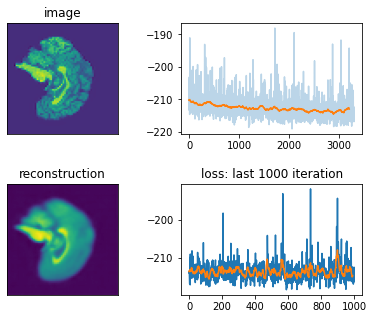

 99%|████████████████████████████████████████████████████████████████████████████▎| 4955/4999 [42:30<00:21,  2.04it/s]

1/1 [==============================] - 0s 19ms/step


 99%|████████████████████████████████████████████████████████████████████████████▎| 4956/4999 [42:30<00:18,  2.31it/s]

1/1 [==============================] - 0s 19ms/step


 99%|████████████████████████████████████████████████████████████████████████████▎| 4957/4999 [42:30<00:16,  2.55it/s]

In [10]:
nbatches = 5000
if train_vae:
    for i in tqdm(range(1,nbatches)):    
        
        batch_idx = np.random.randint(low=0,high=BRAIN_data.shape[0],size=batch_size)
        data_batch = BRAIN_data[batch_idx,:,:,:]
        
        history = vae.train_on_batch(data_batch);
        mse = ((data_batch-vae.predict(data_batch)[:,:,:,:,0])**2).mean()
        loss.append(history);
        
        if np.mod(i,5)==0: # Plot training progress
            im1 = data_batch[0,32,:,:];
            im = vae.predict(data_batch)[0,32,:,:,0];
            plot_trainProgress(loss,im,im1);

        if np.mod(i,10)==0: # Save every 10 batches
            pickle.dump(loss,open(fn+'_loss.pickle','wb'))
            print(i)
            vae.save_weights(fn)    
        
        if mse < .0001:
            break

## CVAE

In [11]:
train_cvae = True
if train_cvae:
    
    latent_dim = 16
    batch_size = 16
    beta = 1;gamma = 100
    disentangle = True
    cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CVAE_3D(latent_dim=latent_dim,beta=beta, disentangle=disentangle, gamma=gamma, bias=True, batch_size = batch_size)
    loss = list()    
    
    fdir = '/mmfs1/data/liacz/Documents/Bilingualism_CVAE/data/tf_outputs/CVAE/'
    fn = 'CVAE_weights'
    
    fn = os.path.join(fdir,fn)
    loss = []

In [12]:
# print(fn)

In [13]:
# z_encoder.summary(line_length=100)

In [14]:
# cvae_decoder.summary(line_length=100)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

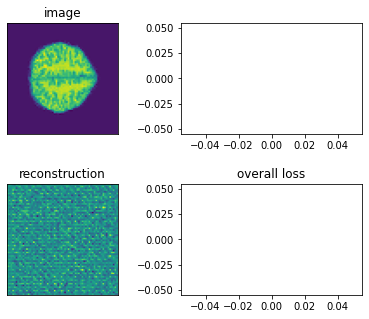

In [15]:
DX_batch = DX_subs[np.random.randint(low=0,high=DX_subs.shape[0],size=batch_size),:,:,:];
TD_batch = TD_subs[np.random.randint(low=0,high=TD_subs.shape[0],size=batch_size),:,:,:];

if len(loss)==0:
    loss.append(np.nan)
    im,im1,ss = cvae_query(BRAIN_data,s_encoder,z_encoder,cvae_decoder);
    plot_trainProgress(loss,im,im1);
    loss = list()
else:
    im,im1,ss = cvae_query(BRAIN_data,s_encoder,z_encoder,cvae_decoder);
    plot_trainProgress(loss,im,im1);

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

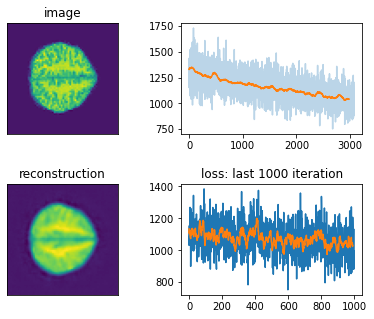

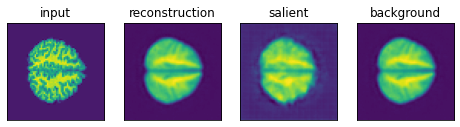

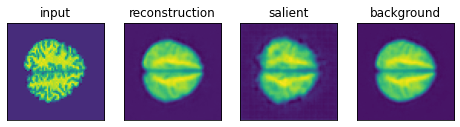

 92%|█████████████████████████████████████████████████████████████████████▏     | 4615/4999 [1:15:23<06:24,  1.00s/it]

2/2 [==============================] - 0s 19ms/step


 92%|█████████████████████████████████████████████████████████████████████▎     | 4616/4999 [1:15:24<05:43,  1.11it/s]

2/2 [==============================] - 0s 19ms/step


 92%|█████████████████████████████████████████████████████████████████████▎     | 4617/4999 [1:15:25<05:14,  1.21it/s]

2/2 [==============================] - 0s 20ms/step


In [16]:
nbatches = 5000
if train_cvae:
    for i in tqdm(range(1,nbatches)):
        
        DX_batch = DX_subs[np.random.randint(low=0,high=DX_subs.shape[0],size=batch_size),:,:,:];
        TD_batch = TD_subs[np.random.randint(low=0,high=TD_subs.shape[0],size=batch_size),:,:,:];
        
        hist = cvae.train_on_batch([DX_batch,TD_batch]);
        loss.append(hist);
        
        mse = ((np.array([DX_batch,TD_batch])-np.array(cvae.predict([DX_batch,TD_batch]))[:,:,:,:,:,0])**2).mean()

        assert not np.isnan(hist),'loss is NaN - somethings wrong'

        im,im1,ss = cvae_query(BRAIN_data, s_encoder, z_encoder, cvae_decoder); 

        

        if np.mod(i,5)==0: # Plot training progress
            plot_trainProgress(loss,im,im1);
            pickle.dump(loss,open(fn+'_loss.pickle','wb'))
            plot_four(DX_batch, TD_batch, z_encoder, s_encoder,cvae_decoder,cvae,idx=0)
            plot_four(DX_batch, TD_batch, z_encoder, s_encoder,cvae_decoder,cvae,idx=1)

        if np.mod(i,10)==0: # Save every 10 batches
            cvae.save_weights(fn)
            
        if mse < .0001:
            break